In [1]:
# Setup the environment first

# read: https://github.com/mirnylab/cooler/issues/138 for more details:

# !export MKL_NUM_THREADS=1 - # not working in a notebook ((
# instead do this, after making sure mkl is installed
import mkl
mkl.set_num_threads(1)



In [2]:
# are you developing?
# turn module reloading on

# %load_ext autoreload
# %autoreload 2

In [3]:
# neccessary modules to be imported

import os.path as op
from scipy.stats import poisson
import pandas as pd
import numpy as np
import cooler

from cooltools import dotfinder

%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker

In [4]:
# input files to play with
# pick Rao et al primary @10kb to enable comparison

# what I have here is Rao et al 2014 sample for GM cells
# the dataset that they refer to as "primary" in the paper
# the cooler created using hic2cool tool
# and what I have here is an older version before divisive/multiplicative
# balancing weights situation happened
path = "/home/venevs/DOTS_TESTING/prim_rep_rao_Mar19"
basename = "GM12878_insitu_primary_30.KR"

# this is a 10kb cooler file
# and we should also have expected calculated for 10kb

COOL10="{}/{}.cool".format(path,basename)
EXP10="{}/{}.cis.expected".format(path,basename)

LOOP10="{}/cloops_{}.bedpe".format(path,basename)
# # HDF10=test_scores$TESTIDX\_$BASENAME.10000.hdf
FLOOP10="{}/cloops_{}.bedpe.postprocess".format(path,basename)

RAOLOOPS="/home/venevs/DOTS_TESTING/rao_combined_hic/Rao2014_GM12878_primary_and_replicate_HiCCUPS_looplist.txt"
RAOLOOPS="/home/venevs/DOTS_TESTING/prim_rep_rao/Rao2014_GM12878_primary_HiCCUPS_looplist.txt"

# keeping some of the relevant CLI commands here
# useful for preprocessing cooler files - before calling dots

# 0. consider adding downloading command for Rao data e.g.
# 0. also condsider showing hic2cool usage here to turn .hic to .cool

# 1. re-balancing - cis-only is worth checking out at the very least ...
# cooler balance -p {threads} --ignore-diags 1 --force --name 'wsnake' {input}::/resolutions/{res}

# 2. calculation of expected
# cooltools compute-expected -p {threads} --weight-name 'wsnake' --drop-diags 1 {input[0]}::/resolutions/{res}


### provide arguments to replace CLI interface

instead of providing comman line arguments to the `call-dots` tool we are going to provide corresponding argumnets right in the notebook:

In [5]:
# specify parameters for call-dots
cool_path = COOL10
expected_path = EXP10
expected_name = 'balanced.avg'
nproc = 8
max_loci_separation = 1000000
max_nans_tolerated = 4
tile_size = 10000000
fdr = 0.1
dots_clustering_radius = 21000
verbose = True
balancing_weight_name = "weight"
output_scores = 'xxx'
output_hists = 'yyy'
output_calls = 'zzz'
score_dump_mode = 'parquet'
# score_dump_mode = 'local'
temp_dir = './'
no_delete_temp = True

### load cooler and expected

In [6]:
clr = cooler.Cooler(cool_path)

expected_columns = ['chrom', 'diag', 'n_valid', expected_name]
expected_index = ['chrom', 'diag']
expected_dtypes = {
    'chrom': np.str,
    'diag': np.int64,
    'n_valid': np.int64,
    expected_name: np.float64
}
expected = pd.read_table(
    expected_path,
    usecols=expected_columns,
    index_col=expected_index,
    dtype=expected_dtypes,
    comment=None,
    verbose=verbose)
# include Geoff's fix for the datatypes in expected

Tokenization took: 46.16 ms
Type conversion took: 19.26 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 31.21 ms
Type conversion took: 18.80 ms
Parser memory cleanup took: 0.00 ms
Tokenization took: 9.84 ms
Type conversion took: 6.06 ms
Parser memory cleanup took: 0.00 ms


### we'll do everyhting for `chr1` only to save time (reconsider it later ...)

demonstration purposes only this way ...

In [7]:
# beware of chromosome naming converntion, i.e. "chr1" vs "1" ...
expected = expected.loc[["1"]]

### some validation
Just making sure that expected anb cooler are "compatible"
i.e. they refer to the same chromosomes and those chromosomes have the same length

In [8]:
# Input validation
# unique list of chroms mentioned in expected_path
# do simple column-name validation for now
get_exp_chroms = lambda df: df.index.get_level_values("chrom").unique()
expected_chroms = get_exp_chroms(expected)
if not set(expected_chroms).issubset(clr.chromnames):
    raise ValueError(
        "Chromosomes in {} must be subset of ".format(expected_path) +
        "chromosomes in cooler {}".format(cool_path))
# check number of bins
# compute # of bins by comparing matching indexes
get_exp_bins = lambda df, ref_chroms: (
    df.index.get_level_values("chrom").isin(ref_chroms).sum())
expected_bins = get_exp_bins(expected, expected_chroms)
cool_bins = clr.bins()[:]["chrom"].isin(expected_chroms).sum()
if not (expected_bins == cool_bins):
    raise ValueError(
        "Number of bins is not matching: ",
        "{} in {}, and {} in {} for chromosomes {}".format(
            expected_bins,
            expected_path,
            cool_bins,
            cool_path,
            expected_chroms))
if verbose:
    print("{} and {} passed cross-compatibility checks.".format(
        cool_path, expected_path))

/home/venevs/DOTS_TESTING/prim_rep_rao_Mar19/GM12878_insitu_primary_30.KR.cool and /home/venevs/DOTS_TESTING/prim_rep_rao_Mar19/GM12878_insitu_primary_30.KR.cis.expected passed cross-compatibility checks.


### prepare some other parameters 

In [9]:
# Prepare some parameters.
binsize = clr.binsize
loci_separation_bins = int(max_loci_separation / binsize)
tile_size_bins = int(tile_size / binsize)
balance_factor = 1.0  #clr._load_attrs("bins/weight")["scale"]

print("we are dealing with the data binned at {}".format(binsize))

# clustering would deal with bases-units for now, so supress this for now
# clustering_radius_bins = int(dots_clustering_radius/binsize)

# pre-defined kernel types that are going to be used in the analysis
ktypes = ['donut', 'vertical', 'horizontal', 'lowleft']

we are dealing with the data binned at 10000


### Kernels used to define local enrichment of a pixel

 - Dots observed on Hi-C heatmaps as *small* and concentrated clusters of locally enriched pixels.
 - Biologically relevant sizes of such clusters and their surroundings are empirically defined at `~50kb` for the diameter of clusters, and `~100kb` for the diameter of the local surrounding
 - Several types of kernels (i.e. local environments) could be used to rule out unwanted enrichment types, e.g. elongated clusters, large corners, etc.
 - One can choose from pre-defined set of kernels from *Rao et al 2014*, or provide custome ones
 - Even for the predefined set of kernels one can control their parameters `w` and `p`, where `2w+1` is the outter dimensions of kernel's footprint and `2p+1` is the inner one, the approximate size of an enriched cluster of pixels
 - function `recommend_kernel_params` would yield recommended `w` and `p` for a given bin size, as in *Rao et al 2014*, otherwise feel free to experiment with those

In [10]:
w,p = dotfinder.recommend_kernel_params(binsize)
print("Kernel parameters w={} p={}".format(w,p))

Kernel parameters w=5 p=2


In [11]:
kernels = {k: dotfinder.get_kernel(w, p, k) for k in ktypes}

# list of tile coordinate ranges
tiles = list(
    dotfinder.heatmap_tiles_generator_diag(
        clr,
        expected_chroms,
        w,
        tile_size_bins,
        loci_separation_bins
    )
)   

[Text(1, 0, 'Excluded from calculation'),
 Text(1, 0, 'Included in calculations')]

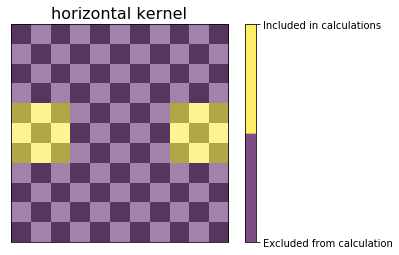

In [12]:
# it is important to demonstrate filters here 
# consider moving plotting code elsewhere or simplify it significantly ...
# split cell above and demonstrate kernels - it's nice:

ktype='horizontal'
kernel= kernels[ktype]
y,x = np.ogrid[-w:w+1, -w:w+1]

extent = (0-0.5,
          x.size-0.5,
          0-0.5,
          y.size-0.5)
########################
plt.clf()
# axes setup
ax = plt.gca()
# discrete colormap with 2 colors ...
cmap = colors.ListedColormap([plt.cm.viridis(0),
                              plt.cm.viridis(1.0)])
# kernel:
imk = ax.imshow(kernel,
                alpha=0.7,
                cmap=cmap,
                extent=extent,
                interpolation='nearest')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels('',visible=False)
ax.set_yticklabels('',visible=False)
ax.set_title("{} kernel".format(ktype),fontsize=16)

# add checkerboard to depict pixels:
checkerboard = np.add.outer(range(x.size),
                            range(y.size)) % 2
ax.imshow(checkerboard,
        cmap=plt.cm.gray,
        interpolation='nearest',
        extent=extent,
        alpha=0.3)
#####################
# colorbar and that's it:
cb = plt.colorbar(imk)
cb.ax.get_yaxis().set_major_locator(ticker.MaxNLocator(1))
cb.ax.set_yticklabels(['Excluded from calculation','Included in calculations'])

### Getting to the calculations of locally-adjusted expected

 - for demonstration and debugging purposes we are going to dump the dataframe with locally adjusted expected right in place (i.e. in memory).
 - This might be also ok for smaller genomes and potentially for small subsets of large genomes.
 - This is not recommended whatsoever for genome-wide dot-calling.

A side note, we've tried to store all of the values in a separate file,
but practice shows that for large genomes even parquet/hdf5 are not fast enough.
Thus using a **2-pass** strategy seems to be the best option indeed.

**2-pass**: calculate locally-adjusted expected for each pixel and use this value *immediately* to build a histogram with predefined bins, then recalculate locally-adjusted expected values and again use them *in place* to select significantly enriched pixels.


 - an example on how to store locally adjusted expected in a temporary file:
```python
import tempfile
tmp_scores = tempfile.NamedTemporaryFile(
    suffix='.parquet',
    delete= False,
    dir='.')
```
 - now calculate locally adjusted expected (not performed in the call-dots command line implementation):
```python
loc_adj_exp = dotfinder.scoring_step(clr,
                    expected,
                    expected_name,
                    "weight",
                    tiles,
                    kernels,
                    max_nans_tolerated,
                    loci_separation_bins,
                    tmp_scores,
                    nproc,
                    score_dump_mode,
                    verbose)
```
 - histogramming using temporary input (this steps is performed in actual call-dots implementation and it involves de novo calculation of locally adjusted expected for each surveyed pixel):
```python
gw_hist = dotfinder.histogramming_step(tmp_scores,
                                    score_dump_mode,
                                    kernels,
                                    ledges,
                                    output_path=None,
                                    nproc=1,
                                    verbose=False)
```

In [95]:
# locally adjusted returned in place for just 1 chromosome:
# beware: this step is not performed in the actual call-dots CLI implementation
la_exp = dotfinder.scoring_step(clr,
                    expected,
                    expected_name,
                    balancing_weight_name,
                    tiles,
                    kernels,
                    1,
                    loci_separation_bins,
                    None,
                    nproc,
                    "local",
                    verbose)

Preparing to convolve 49 tiles:
creating a Pool of 8 workers to tackle 49 tiles
returning local copy of the dataframe ...


### that is how locally adjusted expected dataframe looks like:

bin1_id|bin2_id|count|la_exp.donut.value|la_exp.vertical.value|la_exp.horizontal.value|la_exp.lowleft.value
---|---|---|---|---|---|---
76|87|20|16.343724585366036|19.112339277607475|14.789222300465001|17.55971648783403
76|88|29|21.109446293886823|23.76004284738352|19.119195822013385|23.30209962326733
76|89|15|17.254427190306977|18.545853810657224|14.695003640984938|19.784933947834944
76|90|21|14.277047600786759|14.642767228999286|12.928217571836717|17.27371365389384
76|91|13|11.22588212884422|11.279966641429564|10.064704945467405|14.514049136987758

 - here we use `cooler`-based `bin1/2_id` instead of actual genomic coordinates for compactness and performance reasons.
 - Observed is recorded in the `count` columns, again as in the parent `cooler`-file.
 - observer and all types of expected are expressed in the raw units in order to apply Poisson statistics to the data


### Now let's load in, some known called/annotated dots to see where they end up on the obs/exp scatter-plot

In [96]:
# let us read in some of the known dots to display stronger ones on the obs/exp scatter plot:
raodots = pd.read_csv(RAOLOOPS,sep='\t')
# beware of the UCSC/NCBI chromosome naming conventions `X` vs `chrX` ...
raodots_chr1 = raodots[raodots['chr1']=='1']

# do we need a notion of strength here ?
# #let's quickly define some measure of strengths for the dots:
# raodots_chr1['strength'] = raodots_chr1['o']/raodots_chr1['e_donut']
# # now sort and select only the strongest (according to this measure):
# raodots_chr1_strong = raodots_chr1.sort_values(by=['o','strength'],ascending=False)

# let's convert genomic coordinates into `cooler`-based bin_id-s:
bin1_ids = (raodots_chr1['x1']/binsize).astype('int')
bin2_ids = (raodots_chr1['y1']/binsize).astype('int')
# beware Rao et al, use x1,x2 for start1,end1 and y1,y2 for start2,end2

# now let's look up these called/annotated dots in our pre-calculated la_exp dataframe:
rao_dots_idxs = list(zip(bin1_ids,bin2_ids))
la_exp_indexed = la_exp.set_index(['bin1_id','bin2_id'])

# these are the rao-dots that we have caculated locally adjusted expected for:
intersect_raodots = la_exp_indexed[la_exp_indexed.index.isin(rao_dots_idxs)]
# we don't have for every rao-dot since we don't get close enough to diagonal and
# potentially treat NaNs differently.

### obs/exp scatter

 - let's plot a scatter of obs/exp for a subsample of surveyed pixels
 - highlight called rao-dots on this scatter plot
 - we need subsampling because there are a LOT of pixels

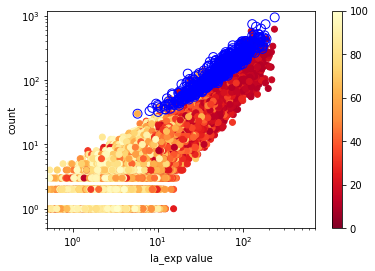

In [97]:
xlabel = 'la_exp.donut.value'
ylabel = 'count'

# we might consider "downsampling" la_exp dataframe in order to make obs/exp scatter plot less busy:
sub_la_exp = la_exp.sample(frac=0.1)

sct = plt.scatter(sub_la_exp[xlabel],
                  sub_la_exp[ylabel],
                  # color dots on the scatter by their genomic separation
                  c=sub_la_exp['bin2_id']-sub_la_exp['bin1_id'],
                  vmin=0,
                  vmax = 100,
                  cmap="YlOrRd_r")



plt.scatter(intersect_raodots[xlabel],
            intersect_raodots[ylabel],
            s=80,
            facecolors='none',
            edgecolors='b')

# we can add a visual of the lambda-chunking grid on top of obs/exp scatter ...
# plt.vlines(ledges[1:-15],ymin=0.5,ymax=900,color='red')

ax = plt.gca()
fig = plt.gcf()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(0.5,700)
ax.set_ylim(0.5,1200)

ax.set_ylabel("count")
ax.set_xlabel("la_exp value")

fig.colorbar(sct)

# starting from here it requires more cleaning/trimming down ...

### we can do some quick and educational statistics here

*Null hypothesis*: intensity of a HiC pixel is Poisson-distributed with a certain expected. In the case of dot-calling procedure, that would be *locally-adjusted expected*.

Thus for the dot-calling, we could estimate a p-value for each of the pixel's intensities (for all of the kernel-types):

```
p =1-Poisson.cdf(obs,exp)
```

In [29]:
from scipy.stats import poisson

for k in ktypes:
    la_exp["la_exp."+k+".pval"] = 1.0 - \
            poisson.cdf(la_exp["count"],
                        la_exp["la_exp."+k+".value"])


### now let's select pixels that are "significantly" brighter than their surroundings ...

Just use *naive* p-value thresholding for simplicity and quick turn around.

And then see where such "bright" pixels end up on the obs/exp scatter plot depending on the p-value threshold

In [98]:
# arbitrary p-value threshold
p_th = 0.0001

# let's test p-value for all of the 4 filters - feel free to play with individual filters/kernels as well:
signif_pvals = np.ones_like(la_exp["la_exp.donut.pval"].values,dtype=np.bool)
for k in ktypes:
    signif_pvals = signif_pvals & (la_exp["la_exp."+k+".pval"]<=p_th)


# plotting - consider making it shorter:
sct = plt.scatter(sub_la_exp[xlabel],
                  sub_la_exp[ylabel],
                  # color dots on the scatter by their genomic separation
                  c=sub_la_exp['bin2_id']-sub_la_exp['bin1_id'],
                  vmin=0,
                  vmax = 100,
                  cmap="YlOrRd_r")

# let's select pixels with "small" p-values:
kinda_signif_pixels = la_exp[signif_pvals]

plt.scatter(kinda_signif_pixels[xlabel],
            kinda_signif_pixels[ylabel],
            s=80,
            facecolors='none',
            edgecolors='b')

# we can add a visual of the lambda-chunking grid on top of obs/exp scatter ...
# plt.vlines(ledges[1:-15],ymin=0.5,ymax=900,color='red')

ax = plt.gca()
fig = plt.gcf()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(0.5,700)
ax.set_ylim(0.5,1200)

ax.set_ylabel("count")
ax.set_xlabel("la_exp value")

fig.colorbar(sct)

KeyError: 'la_exp.donut.pval'

### Rao et al 2014 statistics is more nuanced

 1. Simple p-value thresholding should be replaced to more "productive" FDR, which is more tractable and better suited for the job.
 2. Another argument is that it is "unfair" to treat all of the pixels with the same statitical testing (multiple hypothesis) - the range of "expecteds" is "too wide"
 3. 2nd point is addressed by spliting the pixels in the groups by their localy adjusted expected - the so-called $\lambda$-chunking
 4. Another nuance of $\lambda$-chunking is that Rao et al are using the upper boundary of each $\lambda$-chunk as an expected for every pixel in the chunk (clearly for technical reasons) - we could see how that affects the significance by itself.

(-100, 8500)

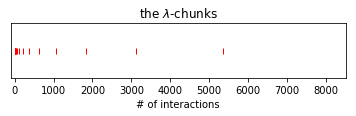

In [99]:
# The essence of lambda-chunking - let's split the surveyed pixels into "chunks" based on
# their la-expected value and do multiple hypothesis testing separately for these chunks.
nlchunks = dotfinder.HiCCUPS_W1_MAX_INDX
base = 5 ** (1/3)
ledges = np.concatenate((
    [-np.inf],
    np.logspace(0, nlchunks - 1, num=nlchunks, base=base, dtype=np.float),
    [np.inf]))

#################################################
plt.plot(ledges,np.zeros_like(ledges),'r|')
plt.title("the $\lambda$-chunks")
plt.xlabel("# of interactions")
fig = plt.gcf()
fig.set_size_inches(6,1)
ax = plt.gca()
ax.set_yticks([])
ax.set_xlim(-100,8500)

# consider embedding this picture to the markdown section ...

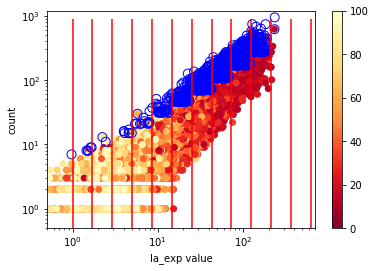

In [100]:
# here are trying to see the effect of using the chunk boundary as an expected instread of actual expected for a given pixel:

# we can exaggerate the "ledges", i.e. make lambda-chunks very wide to see the side effect of replacing expected within each chunk

for k in ktypes:
    la_exp["la_exp."+k+".value.chunked"] = ledges[np.digitize(la_exp["la_exp."+k+".value"],ledges)]
    
# recalculate the p-values to take 4th item into account:
for k in ktypes:
    la_exp["la_exp."+k+".pval"] = 1.0 - \
            poisson.cdf(la_exp["count"],
                        la_exp["la_exp."+k+".value.chunked"])

    
# arbitrary p-value threshold
p_th = 0.0001

# let's test p-value for all of the 4 filters - feel free to play with individual filters/kernels as well:
signif_pvals = np.ones_like(la_exp["la_exp.donut.pval"].values,dtype=np.bool)
for k in ktypes:
    signif_pvals = signif_pvals & (la_exp["la_exp."+k+".pval"]<=p_th)


# plotting - consider making it shorter:
sct = plt.scatter(sub_la_exp[xlabel],
                  sub_la_exp[ylabel],
                  # color dots on the scatter by their genomic separation
                  c=sub_la_exp['bin2_id']-sub_la_exp['bin1_id'],
                  vmin=0,
                  vmax = 100,
                  cmap="YlOrRd_r")

# let's select pixels with "small" p-values:
kinda_signif_pixels = la_exp[signif_pvals]

plt.scatter(kinda_signif_pixels[xlabel],
            kinda_signif_pixels[ylabel],
            s=80,
            facecolors='none',
            edgecolors='b')

# we can add a visual of the lambda-chunking grid on top of obs/exp scatter ...
plt.vlines(ledges[1:-15],ymin=0.5,ymax=900,color='red')

ax = plt.gca()
fig = plt.gcf()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(0.5,700)
ax.set_ylim(0.5,1200)

ax.set_ylabel("count")
ax.set_xlabel("la_exp value")

fig.colorbar(sct)

### Assigning pixels to $\lambda$-chunks:

 - After defining the bins for the expected (boundaries of $\lambda$-chunks) let's actually chunk the data
 - this step involves *de novo* calculation of locally adjusted expected
 - l.a. expected is used to build histograms of observed data

In [101]:
gw_hist = dotfinder.scoring_and_histogramming_step(clr,
                                        expected,
                                        expected_name,
                                        balancing_weight_name,
                                        tiles,
                                        kernels,
                                        ledges,
                                        max_nans_tolerated,
                                        loci_separation_bins,
                                        nproc,
                                        verbose)


Preparing to convolve 49 tiles:
creating a Pool of 8 workers to tackle 49 tiles


### determine thresholds using the fdr thing ...

[we should understand a little better - what is going on here with the multiple hypothesis testing, see https://github.com/mirnylab/cooltools/issues/82]

long story short:
 - for each $\lambda$-chunk we are calculating q-values in an efficient way, skipping calculations of p-values for each surveyed pixel
 - in part this is achieved by using upper boundary of each $\lambda$-chunk as an expected for every pixel in this chunk
 - and in part the efficiency comes from collapsing identical observed values, i.e. histogramming
 - to be checked: q-values > 1.0 seem to be weird - we need to check if that is ok
 - also to be comared with the stats-packages implementations - just in case, e.g. `from statsmodels.stats import multitest; multitest.multipletests(pvals,alpha=0.99,method="fdr_bh")`


In [129]:
# this determines observed thresholds for each chunk and corresponding q-values for every observed value
threshold_df, qvalues = dotfinder.determine_thresholds(
    kernels, ledges, gw_hist, 0.99)

### oveview of the 2D histogram 

x-bins corresponding to the $\lambda$-chunks and y-bins correspodning to the observed counts ...

/home/venevs/miniconda3/envs/dots-stable/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'lambda-chunks')

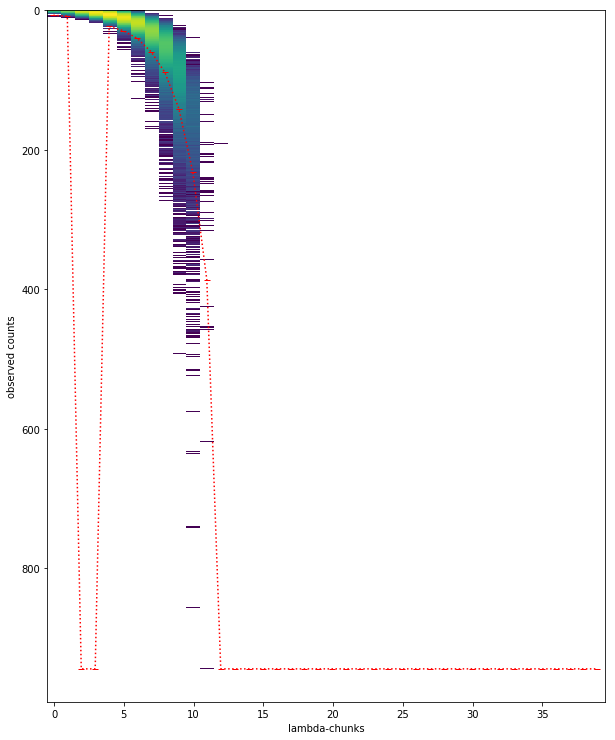

In [137]:
fig = plt.gcf()
fig.set_size_inches(10,30)
plt.imshow(np.log(gw_hist["donut"]),aspect=0.05)
ax = plt.gca()
ax.plot(np.arange(threshold_df["donut"].values.size)-0.05,threshold_df["donut"].values,color='r',marker="_",linestyle=":")

ax.set_ylabel("observed counts")
ax.set_xlabel("lambda-chunks")

### a histogram for a particular $\lambda$-chunk

204896


<BarContainer object of 1 artists>

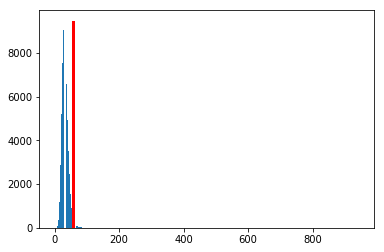

In [140]:
binid = 7
print(gw_hist["donut"].iloc[:,binid].values.sum())
hs = np.clip(gw_hist["donut"].iloc[:,binid].values,a_min=None,a_max=10000)
# hs = np.log(gw_hist["donut"].iloc[:,binid].values)
plt.bar(gw_hist["donut"].iloc[:,binid].index,hs)
plt.bar(threshold_df["donut"].iloc[binid],hs.max(),width=10,color='red')
# plt.gca().set_ylim(0,1)
# plt.gca().set_xlim(0,60)
# gw_hist["donut"].iloc[:,20]

### now extract "significant" pixels using the defined thresholds_df and the same parquet file with the score dump as for the histogramming step



In [143]:
filtered_pixels = dotfinder.scoring_and_extraction_step(clr,
                                        expected,
                                        expected_name,
                                        balancing_weight_name,
                                        tiles,
                                        kernels,
                                        ledges,
                                        threshold_df,
                                        max_nans_tolerated,
                                        balance_factor,                
                                        loci_separation_bins,
                                        None, 
                                        nproc,
                                        verbose)

print("Number of filtered pixels {}".format(len(filtered_pixels)))

Preparing to convolve 49 tiles:
creating a Pool of 8 workers to tackle 49 tiles
Number of filtered pixels 4013


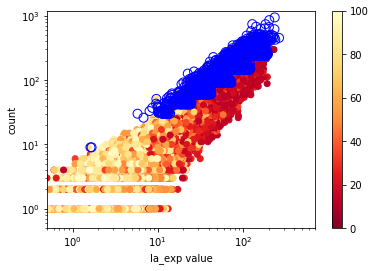

In [145]:
xlabel = 'la_exp.donut.value'
ylabel = 'count'

# we might consider "downsampling" la_exp dataframe in order to make obs/exp scatter plot less busy:
sub_la_exp = la_exp.sample(frac=0.1)

sct = plt.scatter(sub_la_exp[xlabel],
                  sub_la_exp[ylabel],
                  # color dots on the scatter by their genomic separation
                  c=sub_la_exp['bin2_id']-sub_la_exp['bin1_id'],
                  vmin=0,
                  vmax = 100,
                  cmap="YlOrRd_r")



plt.scatter(filtered_pixels[xlabel],
            filtered_pixels[ylabel],
            s=80,
            facecolors='none',
            edgecolors='b')

# we can add a visual of the lambda-chunking grid on top of obs/exp scatter ...
# plt.vlines(ledges[1:-15],ymin=0.5,ymax=900,color='red')

ax = plt.gca()
fig = plt.gcf()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(0.5,700)
ax.set_ylim(0.5,1200)

ax.set_ylabel("count")
ax.set_xlabel("la_exp value")

fig.colorbar(sct)

### annotate filtered pixeles and cluster them -> get centroids after that to proceed with post-processing ...

In [40]:
filtered_pixels_qvals = dotfinder.annotate_pixels_with_qvalues(filtered_pixels,
                                                                qvalues,
                                                                kernels)

In [42]:
filtered_pixels_annotated = cooler.annotate(filtered_pixels_qvals, clr.bins()[:])
centroids = dotfinder.clustering_step(
                            filtered_pixels_annotated,
                            expected_chroms,
                            dots_clustering_radius,
                            verbose)
print("Number of clustered pixels, i.e. centroids {}".format(len(centroids)))

/home/venevs/miniconda3/envs/dots-latest/lib/python3.6/site-packages/sklearn/cluster/birch.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  node1_dist, node2_dist = dist[[farthest_idx]]


Clustering is completed:
6296 clusters detected
3.42+/-3.53 mean size

Clustering is over!
Number of clustered pixels, i.e. centroids 6296


In [45]:
final_out = dotfinder.thresholding_step(centroids)

In [46]:
len(final_out)

2327

## stuff that require clean up, but might be usefull in general 

/home/venevs/miniconda3/envs/dots-stable/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


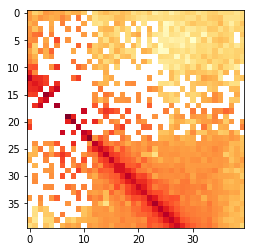

In [21]:
# plt.imshow(np.log(clr.matrix()[18030:18100,18030:18100]),cmap='YlOrRd')
# plt.scatter(53,18,s=80, facecolors='none', edgecolors='b')

bin1,bin2 = 18030+18,18030+53

bin1_n,bin2_n = 18030+23,18030+49


bin1,bin2 = 24322, 24334

plt.imshow(np.log(clr.matrix(balance=True)[bin1-20:bin1+20,bin2-20:bin2+20]),cmap='YlOrRd')

# something to have in mind - is the difference between JUicer balancing and cooler balacning ...
# MAD max filtering in particular
# in Juicer some of thesparse/low coverage regions are kept - what re the effects on the distriubtions, etc
# to be seen
# here is the region for reference: chr1:242,019,651-244,387,558 & chr1:242,713,339-243,695,154 [offset 0,0:0,0]

dddd = cccc[(cccc['bin1_id']==bin1)&(cccc['bin2_id']==bin2)]
eeee = cccc[(cccc['bin1_id']==bin1_n)&(cccc['bin2_id']==bin2_n)]

(cccc['bin2_id']-cccc['bin1_id']).min()

Text(0, 0.5, 'la_exp value')

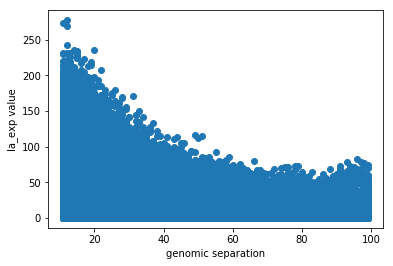

In [73]:
# also supplementary stuff to note
# about the previous point - how do we ended up having super small la_exp at small genomic separatrions ...
xlabel = 'la_exp.donut.value'
ylabel = 'count'

plt.scatter(la_exp['bin2_id']-la_exp['bin1_id'],(la_exp[xlabel]))
# plt.scatter(dddd[xlabel],dddd[ylabel], s=80, facecolors='none', edgecolors='r')
# plt.scatter(eeee[xlabel],eeee[ylabel], s=80, facecolors='none', edgecolors='y')

ax = plt.gca()

ax.set_xlabel("genomic separation")
ax.set_ylabel("la_exp value")